# ADM - HW3 - Places of the world

## Libraries & Setup

In [199]:
import os   # Operating System interaction

from multiprocess import Pool   # Multiprocessing
import pandas as pd   # Data manipulation and analysis
import re   # Regular Expressions

from collections import defaultdict   # Dictionary with default value
import numpy as np   # Scientific Computing
import time   # Execution time measurement
import functools   # Functions manipulation
import nltk   # Natural language processing
import hashlib   # Hashing
import json
import heapq   # Heap data structure
import folium

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from haversine import haversine

import matplotlib.pyplot as plt   # Visualization

import warnings
warnings.filterwarnings('ignore')

import functions

main_path = os.getcwd()

# 1. Data Collection

## 1.1. *Get the list of places*

We start by collecting all the URLs of the places we want to focus on. To do so, we define a function **collect_urls** which retrieves the URLs of the **"Most popular places"** places listed in the first $400$ pages and stores them in a *.txt* file

In [4]:
# Collect URLs
functions.collect_urls('Places URLs.txt')

## 1.2. *Crawl places*

We then proceed by downloading the HTML corresponding to each of the collected URLs. To fulfil this task, the **collect_html_pages** function is defined, which takes in input the pair *(URL, URL index)* for $0<=index<7200$ and outputs the *.hmtl* file, which is then stored in the proper folder, according to the page in which the URL was listed.

In order to *speed up* the retrieval of all the HTML pages, we take advantage of the ability of computer systems to run multiple processors concurrently, known as **multiprocessing**.

A *pool* of $8$ worker processes is set up to download concurrently the HTML pages. The files are retrieved in batches of $100$ to allow for periodic sanity checks. After each step, the integrity of the HTML files in the batch is assessed: in the case of *silent multiprocessing errors*, since the different *workers* process the function calls **asynchronously**, files may be *created* but left *unfilled* (having size of just *few bytes*) or may be missing. If any issue is identified, or if an error arises, the whole batch is downloaded again. This approach allows us to download all the HTML pages $8$ *times faster* than the naive sequential one, while also handling possible *HTTP requests errors*.

In [19]:
# Read URLs from .txt file and store them in a list
urls_list = [line.rstrip() for line in open('Places URLs.txt', 'r')]

# Build a list of pairs (URL, index) for each 0<=index<7200
urls_pairs = [(urls_list[i],i) for i in range(len(urls_list))]

# Retrieve HTML pages
i = 0

while i < len(urls_list):
    try:
        # Initialize a pool of 8 worker processes
        with Pool(8) as p:
            # Download a batch of 100 HTML files using multiprocessing
            p.map(functions.collect_html_pages, urls_pairs[i:i+100])
        # If no HTML file in the batch is corrupted (size of the files > 1 kbytes)
        if all([os.path.getsize("HTML_Pages\Page{}\Doc{}.html".format(k//18 + 1, k + 1)) > 1000 for k in range(i, i+100)]):
            # Go to next batch
            i+=100
        # Otherwise: download again the same batch

    # In the case of any error: try again
    except:
        continue

## 1.3. *Parse downloaded pages*

The HTML pages are then parsed via the **parse_page** function which extracts the desired information from each document and stores them into a *.tsv* file

In [6]:
# Parse HTML pages
for i in range(len(urls_list)):
    functions.parse_page(i, urls_list)

# 2. Search Engine

In [143]:
stemmer = nltk.stem.PorterStemmer()
os.chdir(main_path)
path = './TSV_Files'

In [144]:
Desc = functions.pre_process(path, stemmer)

## 2.1. Conjunctive query

In [145]:
# Retrieve all the unique words in the document description collections
unique_words = set()
for i in Desc: unique_words = unique_words.union(set(Desc[i].split()))

### 2.1.1. Create your index!

Hashing all the distinct words from the documents and creating a vocabulary

In [146]:
# Creating Vocabulary file

def convertToNumber(mystring):
    hash_object = hashlib.md5(mystring.encode())
    return hash_object.hexdigest()

vocabulary = {x: convertToNumber(x) for x in unique_words}

os.chdir(main_path)
with open('vocabulary.json', 'w') as f:
    json.dump(vocabulary, f)

In [147]:
# Computing inverted index
inverted_index = functions.build_inv_idx(Desc, vocabulary)

### 2.1.2. Execute the query

In [148]:
# Input query
query = [x.lower() for x in list(map(stemmer.stem, input().split()))]

In [149]:
query

['american', 'museum']

In [150]:
# Execute query and output result
result, docs = functions.searchText(path, query, inverted_index, vocabulary)
result

,Title,Description,URL
0,Museum of Mourning Art,Mourning and personal response to death are un...,https://www.atlasobscura.com/places/museum-of-...
1,Madam C.J. Walker Museum & WERD Radio,"This small brick building, located just a few ...",https://www.atlasobscura.com/places/madam-cj-w...
2,Museum of Un-Natural History,"Throughout the ’70s and ’80s, Gerald Matthews ...",https://www.atlasobscura.com/places/museum-of-...
3,Sweet Home Cafe,Thomas Downing was the oyster king. In 19th-ce...,https://www.atlasobscura.com/places/sweet-home...
4,Evel Knievel Museum,The Evel Knievel Museum takes you through the ...,https://www.atlasobscura.com/places/evel-kniev...
...,...,...,...
234,Lake Placid Murals,"Founded in 1992, the Lake Placid Mural Society...",https://www.atlasobscura.com/places/lake-placi...
235,The Hobo Museum,"“Decide your own life, don’t let another perso...",https://www.atlasobscura.com/places/the-hobo-m...
236,Murals of Maxo Vanka,Created in protest against industrial capitali...,https://www.atlasobscura.com/places/murals-of-...
237,Lucky Cat Museum,Probably best known to Americans as the cute p...,https://www.atlasobscura.com/places/lucky-cat-...


## 2.2. Conjunctive query & Ranking score

In [151]:
tfidf = TfidfVectorizer()

In [152]:
desc = np.array(list(map(list, Desc.items())))
tfidf_sparse = tfidf.fit_transform(desc[:, 1])
result_dense = tfidf_sparse.todense()

### 2.2.1. Inverted index

In [153]:
important_words = set.intersection(set(vocabulary.keys()), set(tfidf.get_feature_names()))
files = list(desc[:, 0])
names = list(tfidf.get_feature_names())

In [154]:
inverted_index2 = functions.build_inv_idx2(important_words, vocabulary, inverted_index, files, result_dense, names)
inverted_index2

In [155]:
# Cosine similarity
query_vector = tfidf.transform([" ".join(query)])
similarities = cosine_similarity(tfidf_sparse, query_vector).reshape((-1,))

### 2.2.2. Execute the query

In [158]:
# Heap to store and retrieve top-k results
pairs = [(similarities[i], files[i]) for i in range(len(similarities))]

# Filter for documents that contain all words in query
important_pairs = [x for x in pairs if x[1] in docs]

heap, k = [], 20
heapq.heapify(heap)

for el in important_pairs:
    heapq.heappush(heap,el)
    if len(heap)>k:
        heapq.heappop(heap)

In [159]:
result = pd.DataFrame(columns = ['Title', 'Description', 'URL', "Similarity"])
os.chdir(main_path)
os.chdir(path)
for i in range(k):
    pair = heapq.heappop(heap)
    f = open(pair[1], "r", encoding="utf8")
    a = f.read()
    a = re.split(r'\t', a)
    result = result.append({'Title': a[0].strip(),'Description': a[4], 'URL': a[14].strip(), 'Similarity': pair[0]}, ignore_index=True).sort_values(by="Similarity", ascending=False)
    f.close()

In [160]:
result

,Title,Description,URL,Similarity
19,Indian Steps Museum,"Constructed by a local lawyer from 1908-1912, ...",https://www.atlasobscura.com/places/indian-ste...,0.303435
0,Museum of the Weird,The dime or dime store museum is by all accoun...,https://www.atlasobscura.com/places/museum-weird,0.279969
1,Sweet Home Cafe,Thomas Downing was the oyster king. In 19th-ce...,https://www.atlasobscura.com/places/sweet-home...,0.262670
2,Harvard Museum of Natural History,Collecting three different institutions into o...,https://www.atlasobscura.com/places/harvard-mu...,0.257088
3,Siriraj Medical Museum,The Siriraj Medical Museum abounds with medica...,https://www.atlasobscura.com/places/siriraj-me...,0.245090
4,Self-Taught Genius Gallery,"In 2017, the American Folk Art Museum in Manha...",https://www.atlasobscura.com/places/self-taugh...,0.240613
5,Milwaukee Art Museum,Like the Guggenheim in New York and the Oaklan...,https://www.atlasobscura.com/places/milwaukee-...,0.229240
6,National World War II Museum,"Perhaps once thought too narrowly focused, thi...",https://www.atlasobscura.com/places/national-w...,0.219917
7,American Writers Museum,The American Writers Museum—tucked away on the...,https://www.atlasobscura.com/places/american-w...,0.219423
8,Geppi's Entertainment Museum,It’s a unique place that can create a sentimen...,https://www.atlasobscura.com/places/geppi-s-en...,0.206554


# 3. Define a new score!

In the new search engine, the user is asked to input *not only* his **textual query**, but also the name of a **country** he would like the search engine to focus on. The documents are then scored according to the following metrics:

* **Cosine similarity** to the query concerning the **tfIdf** representations of the documents (as in the original search engine)
* The **distance** of the place with respect to the **capital city** of the country specified
* The **Cosine similarity** to the query of the **nearby places** listed

As a measure of distance between cities, the **Haversine distance** is considered, which takes as input the $(latitude, longitude)$ coordinates and outputs a scalar; it ranges between $0$ and $20020$ (*Km*)

The final custom scoring function has the following form:

$$ CosineSimilarity * \frac{Haversine\_dist}{Max\_Haversine\_dist} * (0.5 + \frac{\sum {CosineSimilarity (Nearby\_Places)}} {2*Max\_#\_Nearby\_Places})$$

The **Haversine distance** and the **Cosine similarity** of nearby places are properly normalized, leading the function to be bounded in $[0,1]$

In [174]:
# Input query
query = [x.lower() for x in list(map(stemmer.stem, input("Enter your query: ").split()))]
country = input("Enter the country you would like to visit: ")

In [175]:
query

['american', 'museum']

In [176]:
country

'united states'

In [177]:
# Execute query and output result
os.chdir(main_path)
result, docs = functions.searchText(path, query, inverted_index, vocabulary)
result

,Title,Description,URL
0,Museum of Mourning Art,Mourning and personal response to death are un...,https://www.atlasobscura.com/places/museum-of-...
1,Madam C.J. Walker Museum & WERD Radio,"This small brick building, located just a few ...",https://www.atlasobscura.com/places/madam-cj-w...
2,Museum of Un-Natural History,"Throughout the ’70s and ’80s, Gerald Matthews ...",https://www.atlasobscura.com/places/museum-of-...
3,Sweet Home Cafe,Thomas Downing was the oyster king. In 19th-ce...,https://www.atlasobscura.com/places/sweet-home...
4,Evel Knievel Museum,The Evel Knievel Museum takes you through the ...,https://www.atlasobscura.com/places/evel-kniev...
...,...,...,...
234,Lake Placid Murals,"Founded in 1992, the Lake Placid Mural Society...",https://www.atlasobscura.com/places/lake-placi...
235,The Hobo Museum,"“Decide your own life, don’t let another perso...",https://www.atlasobscura.com/places/the-hobo-m...
236,Murals of Maxo Vanka,Created in protest against industrial capitali...,https://www.atlasobscura.com/places/murals-of-...
237,Lucky Cat Museum,Probably best known to Americans as the cute p...,https://www.atlasobscura.com/places/lucky-cat-...


In [178]:
# Cosine similarity
query_vector_new = tfidf.transform([" ".join(query)])
similarities_new = cosine_similarity(tfidf_sparse, query_vector_new).reshape((-1,))

pairs_new = [(similarities[i], files[i]) for i in range(len(similarities))]

important_pairs_new = [x for x in pairs if x[1] in docs]

In [179]:
# Collect names of places for each file
sim_names = {}
gg = 0
os.chdir(main_path)
os.chdir(path)
for x in pairs_new:
    with open(x[1], 'r', encoding='utf-8') as f:
        a = f.read()
        a = re.split(r'\t+', a)
        name = a[0]
        sim_names[name] = x[0]

In [180]:
# Normalization constants
max_haversine = 20020
max_nearby_places = 3

In [181]:
# Coordinates of all the capital cities in teh world
coords = {}

os.chdir(main_path)
with open("CountryCoords.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(",")
        coords[line[0].lower()]=(float(line[2].strip()),float(line[3].strip()))

coords

{'abkhazia': (43.001525, 41.023415),
 'afghanistan': (34.575503, 69.240073),
 'aland islands': (60.1, 19.933333),
 'albania': (41.327546, 19.818698),
 'algeria': (36.752887, 3.042048),
 'american samoa': (-14.275632, -170.702036),
 'andorra': (42.506317, 1.521835),
 'angola': (-8.839988, 13.289437),
 'anguilla': (18.214813, -63.057441),
 'antarctica': (-90.0, 0.0),
 'antigua and barbuda': (17.12741, -61.846772),
 'argentina': (-34.603684, -58.381559),
 'armenia': (40.179186, 44.499103),
 'aruba': (12.509204, -70.008631),
 'australia': (-35.282, 149.128684),
 'austria': (48.208174, 16.373819),
 'azerbaijan': (40.409262, 49.867092),
 'bahamas': (25.047984, -77.355413),
 'bahrain': (26.228516, 50.58605),
 'bangladesh': (23.810332, 90.412518),
 'barbados': (13.113222, -59.598809),
 'belarus': (53.90454, 27.561524),
 'belgium': (50.85034, 4.35171),
 'belize': (17.251011, -88.75902),
 'benin': (6.496857, 2.628852),
 'bermuda': (32.294816, -64.781375),
 'bhutan': (27.472792, 89.639286),
 'bol

In [182]:
# Custom scoring function
def myscore(x, coords, country):

    os.chdir(main_path)
    os.chdir(path)

    sum_nearby=0
    cos_sim = x[0]
    with open(x[1], 'r', encoding='utf-8') as f:
        try:
            a = f.read()
            a = re.split(r'\t+', a)
            lat, lon = float(a[8]), float(a[9])
            nearby = eval(a[6])
            if isinstance(nearby, list):
                for el in nearby:
                    sum_nearby+=sim_names[el]
            hav = haversine(coords[country], (lat, lon))
        except:
            return 0

    return cos_sim*(hav/max_haversine)*(0.5 + sum_nearby/(2*max_nearby_places))

In [183]:
custom_scores = [(myscore(x, coords, country.lower()), x[1]) for x in important_pairs_new]

In [184]:
# Heap for top-k documents
heap, k = [], 20
heapq.heapify(heap)

for el in custom_scores:
    heapq.heappush(heap,el)
    if len(heap)>k:
        heapq.heappop(heap)

In [185]:
result = pd.DataFrame(columns = ['Title', 'Description', 'URL', "MyScore"])
os.chdir(main_path)
os.chdir(path)
top_k = []
for i in range(k):
    top_k.append(pair[1])
    pair = heapq.heappop(heap)
    f = open(pair[1], "r", encoding="utf8")
    a = f.read()
    a = re.split(r'\t', a)
    result = result.append({'Title': a[0].strip(),'Description': a[4], 'URL': a[14].strip(), 'MyScore': pair[0]}, ignore_index=True).sort_values(by="MyScore", ascending=False)
    f.close()

In [186]:
result

,Title,Description,URL,MyScore
19,Museum of Russian Culture,"When you think San Francisco, you probably don...",https://www.atlasobscura.com/places/museum-of-...,0.016274
0,Museum of the Eye,How do you see the world? Find out at the Muse...,https://www.atlasobscura.com/places/museum-oph...,0.015561
1,Batalion Comic Book Museum and Club,Walking into Prague’sBatalion Comic Book Museu...,https://www.atlasobscura.com/places/batalion-c...,0.013009
2,Pianola Museum,"In a city chock-a-block with museums, one of t...",https://www.atlasobscura.com/places/pianola-mu...,0.012340
3,TinkerTown,Ross Ward began carving wood in junior high sc...,https://www.atlasobscura.com/places/tinkertown,0.009245
4,Crazy Horse Memorial,When the carving of Mount Rushmore began in 19...,https://www.atlasobscura.com/places/crazy-hors...,0.008001
5,Glore Psychiatric Museum,"Located in St. Joseph, Missouri, the Glore Psy...",https://www.atlasobscura.com/places/glore-psyc...,0.007826
6,National Atomic Testing Museum,Las Vegas is an oasis in the desert where no o...,https://www.atlasobscura.com/places/national-a...,0.007043
7,Buckhorn Saloon and Museum,Drink a beer whilst you admire stuffed cougars...,https://www.atlasobscura.com/places/buckhorn-s...,0.006922
8,Milwaukee Art Museum,Like the Guggenheim in New York and the Oaklan...,https://www.atlasobscura.com/places/milwaukee-...,0.005839


The results of the custom search engine are *quite different* from the ones of th purely **cosine similarity** based one, taking into account significantly the country choice made by the user. A *hyperparameter* to balance the weight of each metric in the scoring function could be introduced in order to fine-tune the behaviour of the new system.

# 4. Visualizing the most relevant places

In [220]:
def plot_map(top_k, country):
    data = []
    map = folium.Map(coords[country.lower()], zoom_start=5, height="50%", max_bounds=True, control_scale=True)

    os.chdir(main_path)
    for i in top_k:
        with open(i, "r", encoding="utf8") as f:
            a = f.read()
            a = re.split(r'\t', a)
            name = a[0]
            temp = a[7].split("-")
            city = temp[-2].strip().split(",")[0].strip()
            country = temp[-1].strip()
            address = "-".join(temp[:-2]).strip()
            ppl = a[2]
            lat, lon = float(a[8]), float(a[9])

            html = '''<style type="text/css">
            .tg  {border-collapse:collapse;border-spacing:0;margin:0px auto;}
            .tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
              overflow:hidden;padding:10px 5px;word-break:normal;}
            .tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
              font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
            .tg .tg-3aoq{border-color:inherit;font-family:"Comic Sans MS", cursive, sans-serif !important;font-weight:bold;text-align:center;
              vertical-align:top}
            .tg .tg-am6h{border-color:inherit;font-family:"Comic Sans MS", cursive, sans-serif !important;text-align:center;vertical-align:top}
            </style>
            <head>''' + ''' <center><h3 style='font-family:"Comic Sans MS", cursive, sans-serif !important'>{}</h3>'''.format(name) + '''</center> </head>
            <table class="tg">
            <tbody>
              <tr>
                <td class="tg-3aoq">City</td>
                <td class="tg-am6h">{}</td>
              </tr>
              <tr>
                <td class="tg-3aoq">Country</td>
                <td class="tg-am6h">{}</td>
              </tr>
              <tr>
                <td class="tg-3aoq">Address</td>
                <td class="tg-am6h">{}</td>
              </tr>
              <tr>
                <td class="tg-3aoq">People<br>been here</td>
                <td class="tg-am6h">{}</td>
              </tr>
            </tbody>
            </table>'''.format(city, country, address, ppl)
            popup = folium.Popup(folium.Html(html, script=True), max_width=500)
            folium.Marker(location=[lat, lon], icon=folium.Icon(color="orange", icon="info-sign"), tooltip=name, popup=popup).add_to(map)
    return map

In [221]:
plot_map(top_k, country)

# 7. Theoretical question

In [3]:
applicants_info = functions.read_input()

## *QuickSort*

In [4]:
def partition(array, low, high):

    flag = False

    #checking if arr == dict.items or list of names
    if type(array[0]) == tuple:
        flag = True

    #if dict.items()
    if(flag):
        pivot = array[high][0]

    #if list of names
    else:
        pivot = array[high]
    i = low - 1

    for j in range(low, high):
        #descending order by scores
        if flag:
            if array[j][0] >= pivot:
                i = i + 1
                (array[i], array[j]) = (array[j], array[i])

        #ascending order by names
        else:
            if array[j] <= pivot:
                i = i + 1
                (array[i], array[j]) = (array[j], array[i])

    (array[i + 1], array[high]) = (array[high], array[i + 1])
    return i + 1

def quickSort(array, low, high):
    if low < high:
        pi = partition(array, low, high)
        quickSort(array, low, pi - 1)
        quickSort(array, pi + 1, high)

## *SelectionSort*

In [5]:
def selection_sort(arr):

    flag = False

    #checking if arr == dict.items or list of names
    if type(arr[0]) == tuple:
        flag = True

    for i in range(len(arr)):
        min_i = i
        for j in range(i + 1, len(arr)):

            #descending by score
            if flag:
                if arr[j][0] > arr[min_i][0]:
                    min_i = j

            #ascending by name
            else:
                if arr[j] < arr[min_i]:
                    min_i = j

        arr[i], arr[min_i] = arr[min_i], arr[i]

## *BubbleSort*

In [6]:
def bubbleSort(arr):

    flag = False

    #checking if average_score == dict.items
    if type(arr[0]) == tuple:
        flag = True

    for i in range(len(arr)):
        for j in range(0, len(arr) - i - 1):

            #sort dict.items() by dict.keys()
            if flag:
                if arr[j][0] < arr[j + 1][0]:
                    temp = arr[j]
                    arr[j] = arr[j+1]
                    arr[j+1] = temp

            #if arr is list of names
            else:
                if arr[j] > arr[j + 1]:
                    temp = arr[j]
                    arr[j] = arr[j+1]
                    arr[j+1] = temp

In [7]:
# Custom function to apply sorting algorithms
def my_sort(func, data, qs=False):

    data = list(data.items())

    old = time.time()
    # sort by avg points
    if qs: func(data,0,len(data)-1)
    else: func(data)
    t1 = time.time() - old
    # sort by first and last name
    for i in range(len(data)):
        if len(data[i][1]) != 1:
            a = data[i][1]
            if qs: func(a,0,len(a)-1)
            else: func(a)
            data[i] = (data[i][0], a)
    t2 = time.time() - old

    return t1, t2, data

In [8]:
t1_1, t1, data = my_sort(selection_sort, applicants_info)

In [9]:
t2_1, t2, data = my_sort(bubbleSort, applicants_info)

In [10]:
t3_1, t3, data = my_sort(quickSort, applicants_info, qs=True)

In [11]:
# Write 'RankingList.txt' output file
functions.write_output(data)

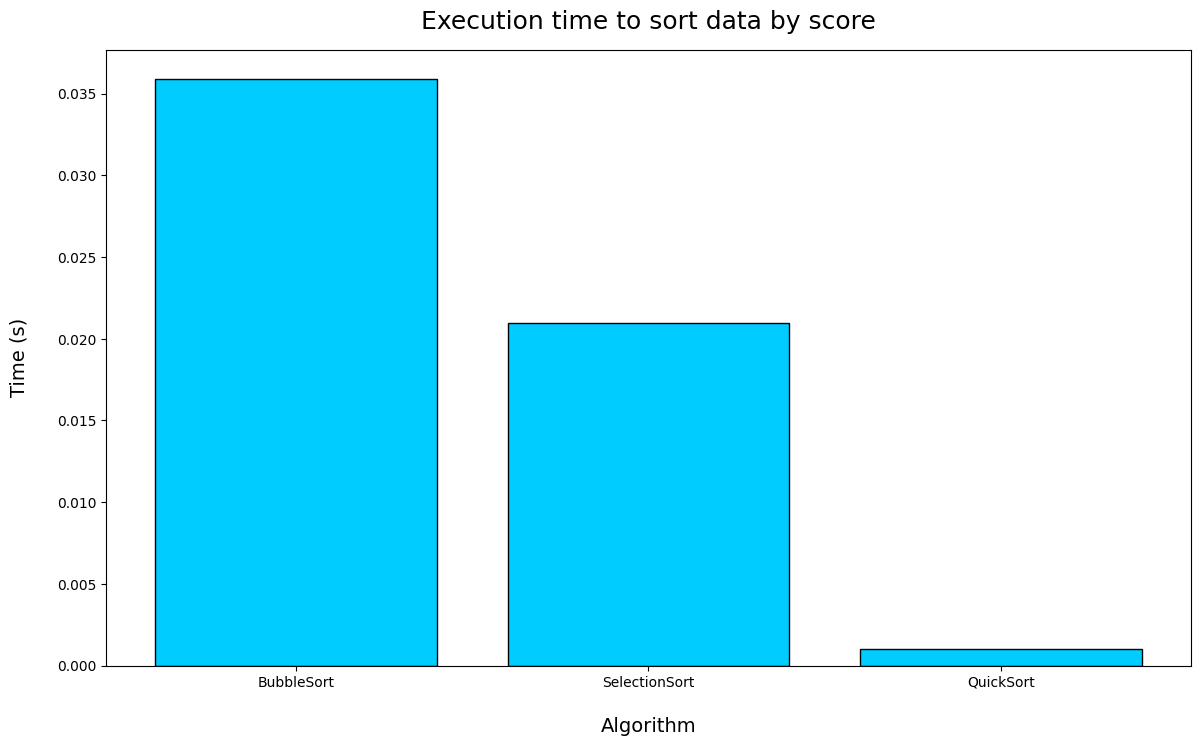

In [12]:
functions.plot_time([t2_1,t1_1,t3_1])

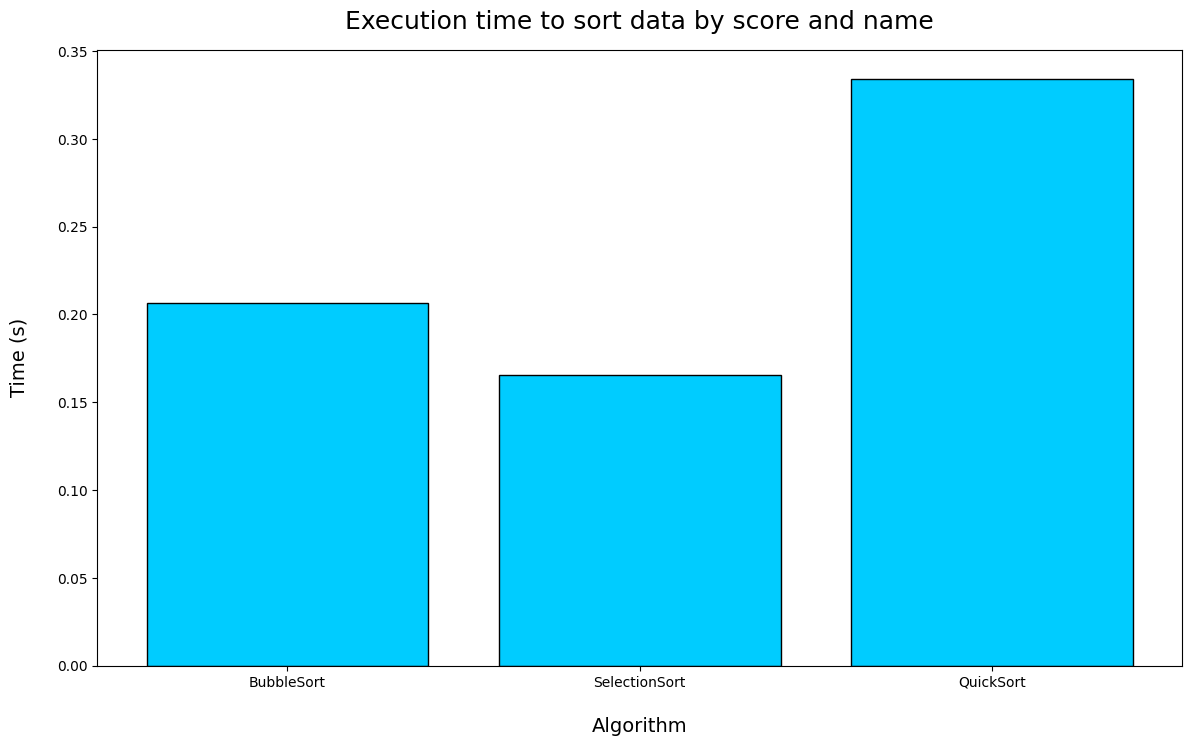

In [13]:
functions.plot_time([t2,t1,t3], alph=True)

#### What is the time complexity of each algorithm you have used?
**BubbleSort**: $O(n^2)$
**SelectionSort**: $O(n^2)$
**QuickSort**: $O(n \cdot log \, n)$ (*worst case* $O(n^2)$)

#### What is the most optimal algorithm, in your opinion, and why?
If we sort the whole data only by **average score**, the most optimal algorithm is **QuickSort**. Quicksort is the *fastest comparison-based sorting algorithm* for many types of data.
If we sort the data by **average score** and then sort students names *alphabetically* - as asked by the exercise instructions - **SelectionSort** algorithm is optimal, presumably thanks to the significantly *small number of write operations* it performs (which may turn out to be quite expensive), while **QuickSort** performs the worst, probably due to the *overhead of recursive calls* which could be non-negligible for small list sizes.

## *MapReduce*

In [14]:
f = open("ApplicantsInfo.txt", "r")
n,m = map(int, f.readline().split())
applicants_info = defaultdict(list)

def myFunc(arg):
    return arg[0]

# Mapping
map_info = []
for i in range(n):
    x = f.readline()
    a = np.array(x.split())
    score = sum(map(int,a[2:]))/len(a[2:])
    map_info.append((score, [' '.join(a[:2])]))
f.close()

# Sorting
old = time.time()
map_info.sort(reverse=True, key=myFunc)

# Reducing
def reducing_func(arg1, arg2):
    first = False
    if type(arg1) == list:
        arg1_temp = arg1[len(arg1)-1]
    else:
        arg1_temp = arg1
        first = True
    if arg1_temp[0] == arg2[0]:

        arg1_temp[1].extend(arg2[1])
        arg1_temp[1].sort()
        if first == False:
            arg1.pop()
            arg1.append(arg1_temp)
            return arg1
        else:
            return (arg1_temp[0], arg1_temp[1])
    else:
        if first == True:
            return [arg1, arg2]
        else:
            arg1.append(arg2)
            return arg1

# MapReduce
a = functools.reduce(reducing_func, map_info)

t4 = time.time() - old

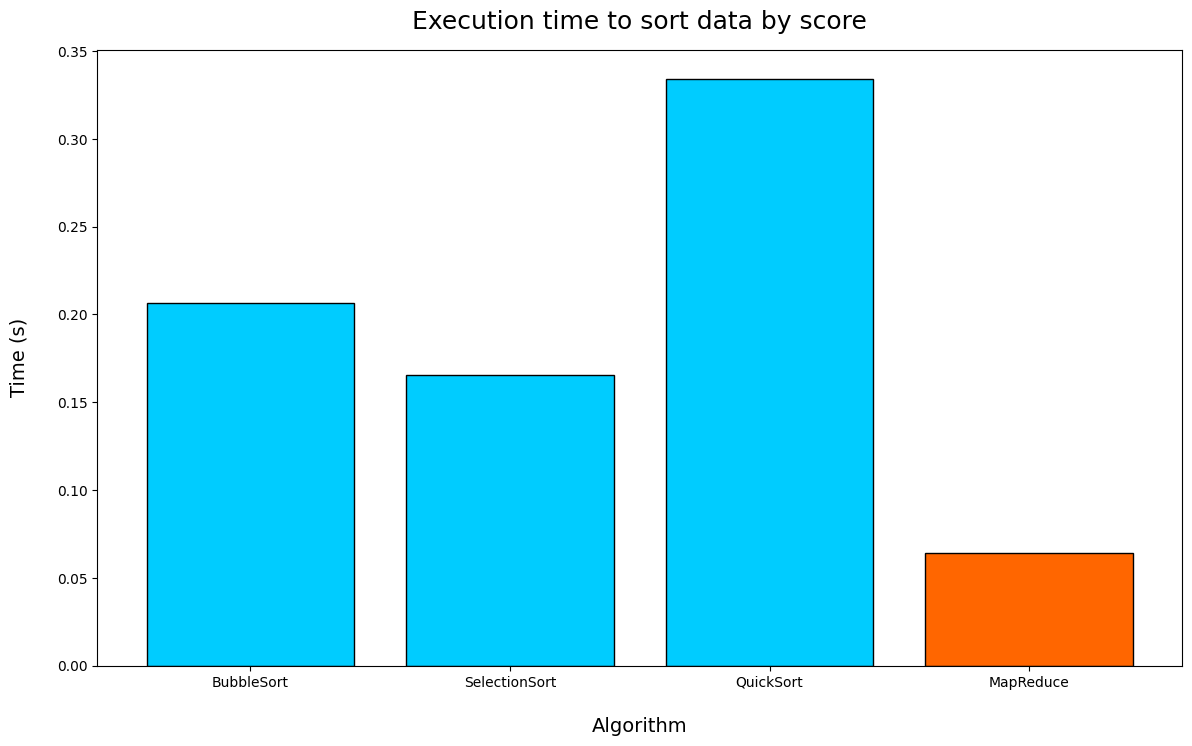

In [15]:
functions.plot_time([t2,t1,t3,t4], mp=True)